In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

## config(kernel使うときに変更すべき変数)

In [162]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

## 画像処理部

__version__

__ver1__<br>
train_concat：CV:????, LB:????


In [163]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [165]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.loc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 50 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [166]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [167]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b0 NN architecture
# skf = StratifiedKFold(n_splits=3, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [168]:
train_df = pd.read_csv(melanoma_external_malignant_256 + 'train_concat.csv')
#train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')

In [169]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [170]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [171]:
test = MelanomaDataset(df=test_df,
                       imfolder = melanoma_external_malignant_256 + 'test/test/', 
                       #imfolder = SIIM_ISIC_Melanoma_Classification + 'jpeg/test/', 
                       train=False,
                       transforms=train_transform,
                       meta_features=meta_features)

In [172]:
%%time
epochs = 10  # Number of epochs to run
model_path = Output + 'model.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

# We stratify by target value, thus, according to sklearn StratifiedKFold documentation
# We can fill `X` with zeroes of corresponding length to use it as a placeholder
# since we only need `y` to stratify the data
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    
    best_val = None  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder= melanoma_external_malignant_256 + 'train/train/',  
                            #imfolder = SIIM_ISIC_Melanoma_Classification + 'jpeg/train/', 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder= melanoma_external_malignant_256 + 'train/train/', 
                            #imfolder = SIIM_ISIC_Melanoma_Classification + 'jpeg/train/', 
                            train=True, 
                            transforms=test_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()

            
        train_acc = correct / len(train_idx)

        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
            # During the first iteration (first epoch) best validation is set to None
            if not best_val:
                best_val = val_roc  # So any validation roc_auc we have is the best one for now
                torch.save(model, model_path)  # Saving the model
                continue
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
        preds /= TTA
        
    del train, val, train_loader, val_loader, x, y, x_val, y_val
    gc.collect()
    
preds /= skf.n_splits

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 114.271 | Train acc: 0.965 | Val acc: 0.944 | Val roc_auc: 0.960 | Training time: 0:04:30
Epoch 002: | Loss: 91.218 | Train acc: 0.972 | Val acc: 0.943 | Val roc_auc: 0.975 | Training time: 0:04:30
Epoch 003: | Loss: 87.809 | Train acc: 0.974 | Val acc: 0.939 | Val roc_auc: 0.961 | Training time: 0:04:31
Epoch 004: | Loss: 81.489 | Train acc: 0.975 | Val acc: 0.954 | Val roc_auc: 0.966 | Training time: 0:04:31
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 66.247 | Train acc: 0.980 | Val acc: 0.955 | Val roc_auc: 0.971 | Training time: 0:04:30
Early stopping. Best Val roc_auc: 0.975
==================== Fold 2 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 119.290 | Train acc: 0.960 | Val acc: 0.969 | Val roc_auc: 0.967 | Training time: 0:04:31
Epoch 002: | Loss: 100.173 | Train acc: 0.968 | Val acc: 0

In [173]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF: 0.974


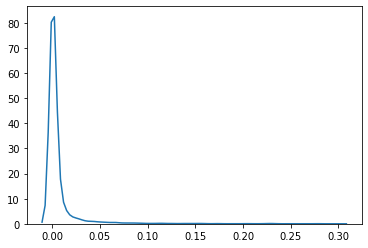

In [174]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [175]:
sub_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
sub_ID['target'] = preds.cpu().numpy().reshape(-1,)
sub_ID.to_csv(Output + 'submission_ID.csv', index=False)

#画像認識モデルのみの投稿(基本はコメントアウト)
#sub.to_csv(Output + 'submission.csv', index=False)

## TableDataモデル部

__version__

__ver1__<br>
ハイパーパラメータ実装&train_concat：CV:0.8992, LB:0.642<br>
__ver2__<br>
train使用&isnul廃止：CV:0.6942 LB:0.642<br>
__ver3__<br>
patient_id使用：CV:0.7164 LB:0.653<br>
__ver4__<br>
train使用&isnul使用：CV:0.7194 LB:0.653<br>
__ver5__<br>
 "subsample_freq": 1,"subsample": 0.9：CV:0.7274 LB:0.664<br>

__initialize__

In [205]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import os

In [206]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [207]:
# startmodel
#train_TD = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
#test_TD  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
#sub_TD   = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
#
#train_TD['sex'] = train_TD['sex'].fillna('na')
#train_TD['age_approx'] = train_TD['age_approx'].fillna(0)
#train_TD['anatom_site_general_challenge'] = train_TD['anatom_site_general_challenge'].fillna('na')
#
#test_TD['sex'] = test_TD['sex'].fillna('na')
#test_TD['age_approx'] = test_TD['age_approx'].fillna(0)
#test_TD['anatom_site_general_challenge'] = test_TD['anatom_site_general_challenge'].fillna('na')
#
#L = 15
#feat = ['sex','age_approx','anatom_site_general_challenge']
#
#M = train_TD.target.mean()
#te = train_TD.groupby(feat)['target'].agg(['mean','count']).reset_index()
#te['ll'] = ((te['mean']*te['count'])+(M*L))/(te['count']+L)
#del te['mean'], te['count']
#
#test_TD = test_TD.merge( te, on=feat, how='left' )
#test_TD['ll'] = test_TD['ll'].fillna(M)
#
#sub_TD.target = test_TD.ll.values
#
#sub_TD.to_csv(Output + 'submission.csv', index=False)

In [208]:
#train_concatとtestに被るデータはない。
train_TD = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_TD = train_TD.drop(['diagnosis','benign_malignant'], axis=1)
#train_TD = pd.read_csv(melanoma_external_malignant_256 + 'train_concat.csv')
test_TD  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
sub_TD   = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

train_TD.shape, test_TD.shape, sub_TD.shape

((33126, 6), (10982, 5), (10982, 2))

In [209]:
#patient_id 削除
#train_TD = train_TD.drop(['patient_id'], axis=1)
#test_TD = test_TD.drop(['patient_id'], axis=1)

__preprocessing__

In [210]:
from sklearn.preprocessing import LabelEncoder

In [211]:
#ラベルエンコード(文字列→数値)
def Label_encode(train, test, feature_name):
    for f in feature_name:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
    
    return train, test

In [212]:
def FillnaAndInsertIsnan(DataFrame, ColsAndFillVals):
    for (col, val) in ColsAndFillVals:
        IsnanSeries = DataFrame[col].isnull()
        DataFrame[col] = DataFrame[col].fillna(val)
        DataFrame.insert(len(DataFrame.columns), col + "_isnan", IsnanSeries)
    return DataFrame

In [213]:
mean_age_approx = train_TD['age_approx'].mean()
train_TD = FillnaAndInsertIsnan(train_TD, [('sex','na'), ('age_approx',mean_age_approx), ('anatom_site_general_challenge','na')])
test_TD = FillnaAndInsertIsnan(test_TD, [('sex','na'), ('age_approx',mean_age_approx), ('anatom_site_general_challenge','na')])

In [214]:
train_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,False,False,False
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,False,False,False
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,False,False,False
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,False,False,False
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,False,False,False


In [215]:
test_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,ISIC_0052060,IP_3579794,male,70.0,na,False,False,True
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,False,False,False
2,ISIC_0058510,IP_7960270,female,55.0,torso,False,False,False
3,ISIC_0073313,IP_6375035,female,50.0,torso,False,False,False
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,False,False,False


In [216]:
print(train_TD.dropna(how='any').shape)
print(test_TD.dropna(how='any').shape)

(33126, 9)
(10982, 8)


In [217]:
feature_name =  ['image_name','patient_id','sex','anatom_site_general_challenge']
#feature_name =  ['image_name','sex','anatom_site_general_challenge']
train_TD, test_TD = Label_encode(train_TD, test_TD, feature_name)

In [218]:
X = train_TD.drop(['image_name','target'], axis=1)
y = train_TD['target']
X_test = test_TD.drop(['image_name'], axis=1)

In [219]:
X.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,1943,1,45.0,0,False,False,False
1,803,0,45.0,6,False,False,False
2,733,0,50.0,1,False,False,False
3,1846,0,45.0,0,False,False,False
4,2368,0,55.0,6,False,False,False


In [220]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [221]:
X_test.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,949,1,70.0,2,False,False,True
1,2092,1,40.0,1,False,False,False
2,2140,0,55.0,5,False,False,False
3,1698,0,50.0,5,False,False,False
4,134,0,45.0,1,False,False,False


__preprocessing end__

__model__

In [222]:
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import time
import seaborn as sns

In [223]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, 
                               plot_feature_importance=False, model=None, verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': 'auc',
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid, num_iteration=model.best_iteration_)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict


__model end__

__run__

In [224]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

Fold 1 started at Fri Jun 26 23:41:16 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.0653208	training's auc: 0.928152	valid_1's binary_logloss: 0.0746855	valid_1's auc: 0.71005
Fold 2 started at Fri Jun 26 23:41:17 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0663815	training's auc: 0.907336	valid_1's binary_logloss: 0.0837475	valid_1's auc: 0.748653
Fold 3 started at Fri Jun 26 23:41:18 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.0666831	training's auc: 0.915123	valid_1's binary_logloss: 0.0761789	valid_1's auc: 0.735419
Fold 4 started at Fri Jun 26 23:41:19 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.0649174	training's

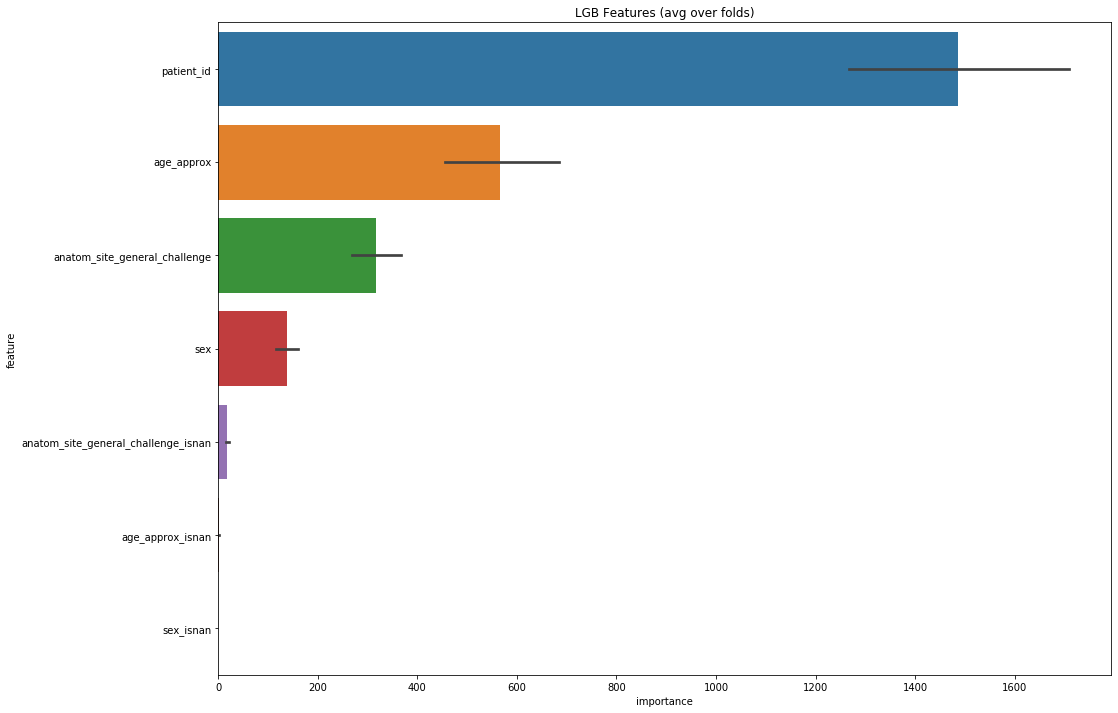

In [230]:
%%time

#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

params = {"boosting_type": "gbdt",
          "learning_rate": 0.01,
          #'max_depth': 7,
          #'num_leaves': 31,
          "subsample_freq": 1,
          "subsample": 0.9,
          #'reg_alpha': 0,
          #'reg_lambda': 0,
         }

#lgb(決定木)で学習実行
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000)

__run end__

In [231]:
sub_TD.target = result_dict_lgb["prediction"][:,1]
sub_TD.head(10)

,image_name,target
0,ISIC_0052060,0.053427
1,ISIC_0052349,0.035240
2,ISIC_0058510,0.008852
3,ISIC_0073313,0.008283
4,ISIC_0073502,0.006845
5,ISIC_0074618,0.010123
6,ISIC_0076801,0.008224
7,ISIC_0077586,0.012996
8,ISIC_0082004,0.011940
9,ISIC_0082785,0.021125


In [232]:
#table dataモデルのpred
sub_TD.to_csv(Output + 'submission_TD.csv', index=False)

#table dataモデルのみの投稿(基本はコメントアウトすること。)
sub_TD.to_csv(Output + 'submission.csv', index=False)


## Ensemble部

In [200]:
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
image_sub = pd.read_csv(Output + 'submission_ID.csv')
tabular_sub = pd.read_csv(Output + 'submission_TD.csv')
tabular_sub.head()

,image_name,target
0,ISIC_0052060,0.050890
1,ISIC_0052349,0.022270
2,ISIC_0058510,0.010786
3,ISIC_0073313,0.009030
4,ISIC_0073502,0.007841


In [202]:
sub = image_sub.copy()
sub.target = 0.9 * image_sub.target.values + 0.1 * tabular_sub.target.values
sub.to_csv(Output + 'submission.csv', index=False)


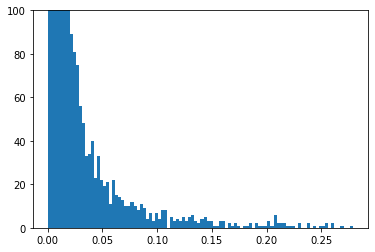

In [203]:
plt.hist(sub.target,bins=100)
plt.ylim((0,100))
plt.show()

## Submit(ここより先はkernelで入れなくて良い)

In [233]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'submission.csv'
message = 'lgb (table only)'
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

100%|██████████| 362k/362k [00:02<00:00, 126kB/s] 


Successfully submitted to SIIM-ISIC Melanoma Classification